In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#     -O /tmp/sunspots.csv
path = r'C:\Users\pmspr\Documents\Machine Learning\Courses\Tensorflow Cert\Data\timeseries'

In [7]:
import csv
import os

time_step = []
sunspots = []

file = os.path.join(path,'sunspots.csv')
with open(file) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

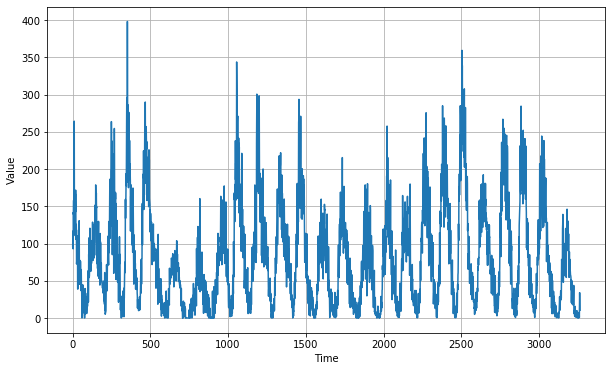

In [8]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [11]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [47]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    cnt=0
    for item in ds.as_numpy_iterator():
        cnt +=1
    print('Number of batches',cnt)
    forecast = model.predict(ds)
    return forecast

In [61]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 4s 352ms/step - loss: 80.2708 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 2s 159ms/step - loss: 78.2509 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 2s 163ms/step - loss: 75.6613 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 2s 169ms/step - loss: 72.3021 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 2s 162ms/step - loss: 69.0173 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 2s 172ms/step - loss: 65.3797 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 2s 168ms/step - loss: 61.9061 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 2s 167ms/step - loss: 58.0653 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 2s 171ms/step - loss: 55.4543 - mae: 55.5682
Epoch 10/100
12/

12/12 [==============================] - 3s 209ms/step - loss: 23.1635 - mae: 23.7546
Epoch 83/100
12/12 [==============================] - 2s 189ms/step - loss: 22.5442 - mae: 22.9474
Epoch 84/100
12/12 [==============================] - 2s 197ms/step - loss: 22.6871 - mae: 23.2211
Epoch 85/100
12/12 [==============================] - 2s 190ms/step - loss: 22.2042 - mae: 22.4436
Epoch 86/100
12/12 [==============================] - 2s 202ms/step - loss: 35.0760 - mae: 35.2150
Epoch 87/100
12/12 [==============================] - 2s 195ms/step - loss: 44.2766 - mae: 44.7667
Epoch 88/100
12/12 [==============================] - 2s 187ms/step - loss: 50.2964 - mae: 50.9594
Epoch 89/100
12/12 [==============================] - 2s 191ms/step - loss: 52.0291 - mae: 52.1781
Epoch 90/100
12/12 [==============================] - 2s 188ms/step - loss: 54.1216 - mae: 54.3770
Epoch 91/100
12/12 [==============================] - 2s 197ms/step - loss: 53.0356 - mae: 52.6189
Epoch 92/100
12/12 [===

[1e-08, 0.0001, 0, 60]

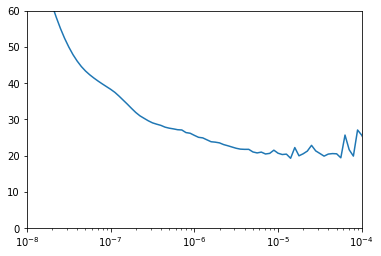

In [62]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [63]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 5s 159ms/step - loss: 37.8969 - mae: 38.6062
Epoch 2/500
30/30 [==============================] - 2s 72ms/step - loss: 24.0752 - mae: 24.6120
Epoch 3/500
30/30 [==============================] - 2s 70ms/step - loss: 22.0253 - mae: 22.5215
Epoch 4/500
30/30 [==============================] - 2s 74ms/step - loss: 19.8251 - mae: 20.3084
Epoch 5/500
30/30 [==============================] - 2s 77ms/step - loss: 19.4540 - mae: 19.9425: 0s - loss: 19.2973 - mae:
Epoch 6/500
30/30 [==============================] - 2s 77ms/step - loss: 19.2296 - mae: 19.7267
Epoch 7/500
30/30 [==============================] - 2s 79ms/step - loss: 18.6098 - mae: 19.0757
Epoch 8/500
30/30 [==============================] - 2s 79ms/step - loss: 18.4703 - mae: 18.9833
Epoch 9/500
30/30 [==============================] - 2s 78ms/step - loss: 18.2440 - mae: 18.7012
Epoch 10/500
30/30 [==============================] - 2s 78ms/step - loss: 18.2437 - mae: 18.7195
E

Epoch 82/500
30/30 [==============================] - 2s 79ms/step - loss: 16.3709 - mae: 16.8798
Epoch 83/500
30/30 [==============================] - 3s 85ms/step - loss: 16.3799 - mae: 16.8466
Epoch 84/500
30/30 [==============================] - 3s 85ms/step - loss: 16.3656 - mae: 16.8451
Epoch 85/500
30/30 [==============================] - 3s 87ms/step - loss: 16.3288 - mae: 16.8124
Epoch 86/500
30/30 [==============================] - 3s 86ms/step - loss: 16.3265 - mae: 16.8038
Epoch 87/500
30/30 [==============================] - 3s 90ms/step - loss: 16.4812 - mae: 16.9505
Epoch 88/500
30/30 [==============================] - 3s 89ms/step - loss: 16.6105 - mae: 17.0612
Epoch 89/500
30/30 [==============================] - 3s 87ms/step - loss: 16.5113 - mae: 17.0061
Epoch 90/500
30/30 [==============================] - 3s 89ms/step - loss: 16.4363 - mae: 16.9377
Epoch 91/500
30/30 [==============================] - 3s 94ms/step - loss: 16.3233 - mae: 16.8057
Epoch 92/500
30/30 [

30/30 [==============================] - 2s 82ms/step - loss: 15.9976 - mae: 16.4711
Epoch 165/500
30/30 [==============================] - 3s 86ms/step - loss: 15.8914 - mae: 16.3523
Epoch 166/500
30/30 [==============================] - 2s 82ms/step - loss: 15.9943 - mae: 16.5006
Epoch 167/500
30/30 [==============================] - 2s 83ms/step - loss: 15.7937 - mae: 16.2776
Epoch 168/500
30/30 [==============================] - 2s 79ms/step - loss: 15.8167 - mae: 16.2869
Epoch 169/500
30/30 [==============================] - 3s 85ms/step - loss: 15.8636 - mae: 16.3415
Epoch 170/500
30/30 [==============================] - 2s 80ms/step - loss: 15.7615 - mae: 16.2571
Epoch 171/500
30/30 [==============================] - 2s 82ms/step - loss: 15.8538 - mae: 16.3322
Epoch 172/500
30/30 [==============================] - 2s 81ms/step - loss: 15.7512 - mae: 16.2346
Epoch 173/500
30/30 [==============================] - 2s 82ms/step - loss: 15.8079 - mae: 16.3080
Epoch 174/500
30/30 [===

30/30 [==============================] - 2s 81ms/step - loss: 15.6421 - mae: 16.1678
Epoch 247/500
30/30 [==============================] - 2s 79ms/step - loss: 15.2694 - mae: 15.7923
Epoch 248/500
30/30 [==============================] - 2s 81ms/step - loss: 15.3742 - mae: 15.8428
Epoch 249/500
30/30 [==============================] - 2s 80ms/step - loss: 15.4325 - mae: 15.8988
Epoch 250/500
30/30 [==============================] - 2s 81ms/step - loss: 15.5133 - mae: 16.0078
Epoch 251/500
30/30 [==============================] - 2s 79ms/step - loss: 15.2400 - mae: 15.7595
Epoch 252/500
30/30 [==============================] - 2s 79ms/step - loss: 15.3656 - mae: 15.8672
Epoch 253/500
30/30 [==============================] - 2s 78ms/step - loss: 15.3207 - mae: 15.8094
Epoch 254/500
30/30 [==============================] - 2s 80ms/step - loss: 15.3190 - mae: 15.8008
Epoch 255/500
30/30 [==============================] - 2s 78ms/step - loss: 15.2390 - mae: 15.7649
Epoch 256/500
30/30 [===

30/30 [==============================] - 2s 80ms/step - loss: 14.8796 - mae: 15.3746
Epoch 329/500
30/30 [==============================] - 2s 79ms/step - loss: 14.9260 - mae: 15.3925
Epoch 330/500
30/30 [==============================] - 3s 84ms/step - loss: 14.8802 - mae: 15.3620
Epoch 331/500
30/30 [==============================] - 2s 80ms/step - loss: 14.9204 - mae: 15.4188
Epoch 332/500
30/30 [==============================] - 2s 83ms/step - loss: 14.8871 - mae: 15.3847
Epoch 333/500
30/30 [==============================] - 2s 83ms/step - loss: 14.9285 - mae: 15.4231
Epoch 334/500
30/30 [==============================] - 2s 79ms/step - loss: 14.8400 - mae: 15.3085
Epoch 335/500
30/30 [==============================] - 2s 81ms/step - loss: 15.0697 - mae: 15.5684
Epoch 336/500
30/30 [==============================] - 2s 83ms/step - loss: 14.9728 - mae: 15.4643
Epoch 337/500
30/30 [==============================] - 2s 78ms/step - loss: 14.8515 - mae: 15.3310
Epoch 338/500
30/30 [===

30/30 [==============================] - 2s 79ms/step - loss: 14.4529 - mae: 14.9210
Epoch 411/500
30/30 [==============================] - 2s 82ms/step - loss: 14.5878 - mae: 15.0741
Epoch 412/500
30/30 [==============================] - 2s 81ms/step - loss: 14.5492 - mae: 15.0383
Epoch 413/500
30/30 [==============================] - 2s 83ms/step - loss: 14.4620 - mae: 14.9443
Epoch 414/500
30/30 [==============================] - 2s 80ms/step - loss: 14.4750 - mae: 14.9610
Epoch 415/500
30/30 [==============================] - 2s 81ms/step - loss: 14.4021 - mae: 14.9069
Epoch 416/500
30/30 [==============================] - 2s 82ms/step - loss: 14.4063 - mae: 14.8763
Epoch 417/500
30/30 [==============================] - 2s 81ms/step - loss: 14.4119 - mae: 14.9149
Epoch 418/500
30/30 [==============================] - 2s 80ms/step - loss: 14.3541 - mae: 14.8328
Epoch 419/500
30/30 [==============================] - 2s 77ms/step - loss: 14.6206 - mae: 15.1360
Epoch 420/500
30/30 [===

30/30 [==============================] - 2s 82ms/step - loss: 14.1731 - mae: 14.6571
Epoch 493/500
30/30 [==============================] - 2s 81ms/step - loss: 14.3109 - mae: 14.7804
Epoch 494/500
30/30 [==============================] - 2s 82ms/step - loss: 14.0870 - mae: 14.5899
Epoch 495/500
30/30 [==============================] - 3s 85ms/step - loss: 14.0952 - mae: 14.5870
Epoch 496/500
30/30 [==============================] - 2s 77ms/step - loss: 14.0888 - mae: 14.5452
Epoch 497/500
30/30 [==============================] - 2s 79ms/step - loss: 14.0416 - mae: 14.5077
Epoch 498/500
30/30 [==============================] - 2s 79ms/step - loss: 14.0080 - mae: 14.4858
Epoch 499/500
30/30 [==============================] - 2s 80ms/step - loss: 13.9767 - mae: 14.4741
Epoch 500/500
30/30 [==============================] - 2s 81ms/step - loss: 13.9519 - mae: 14.4119


In [59]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

# ts = tf.expand_dims(series[0:64, np.newaxis], axis=-1)
# rs = model.predict(ts)
# print(rs)
# print(len(rs))

Number of batches 101


In [33]:
print(train_set.element_spec)
cnt = 0
for item in train_set.as_numpy_iterator():
    cnt += 1
    print(len(item[0]))
    print(len(item[0][1]))
    break
print(cnt)
print(bl)
print(len(rnn_forecast))
print(len(series))

(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
256
64
1
120
265


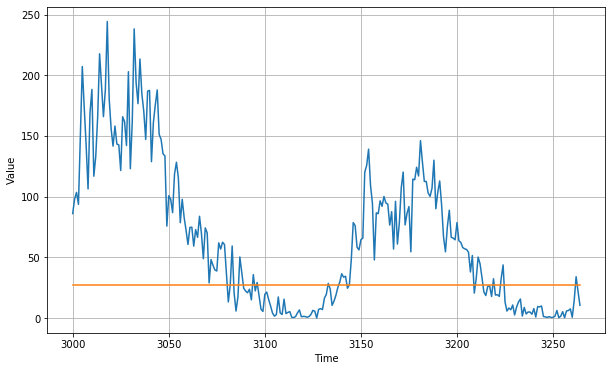

In [64]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [65]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

51.634277

<Figure size 432x288 with 0 Axes>

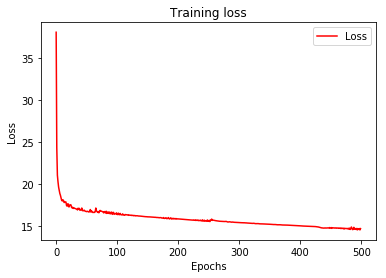

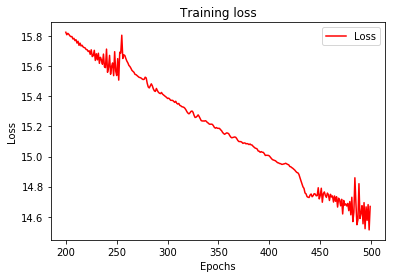

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)

[1.80334488e+02 1.65932495e+02 2.21385651e+02 2.02602341e+02
 1.95812378e+02 1.66568024e+02 1.72221893e+02 1.72351089e+02
 1.71359238e+02 1.92315262e+02 1.79430908e+02 1.90465561e+02
 1.70150406e+02 1.54548752e+02 1.45760834e+02 1.52615173e+02
 1.56858536e+02 1.52650833e+02 1.31245773e+02 1.35252060e+02
 1.27649216e+02 9.58357544e+01 9.90672379e+01 8.83868637e+01
 8.30485153e+01 8.85051575e+01 8.65534286e+01 8.34583511e+01
 1.14608894e+02 1.31056335e+02 1.32336349e+02 1.03073143e+02
 9.93796616e+01 1.11037933e+02 8.51060486e+01 8.48528519e+01
 7.69715576e+01 6.63921509e+01 5.09542046e+01 4.30102539e+01
 4.26469612e+01 3.53892822e+01 4.97657166e+01 5.25579033e+01
 6.69459915e+01 4.63514252e+01 4.48055305e+01 4.08606110e+01
 4.48441048e+01 3.97551613e+01 2.68832245e+01 2.22263908e+01
 3.32603378e+01 1.98383331e+01 3.29938431e+01 2.01695232e+01
 3.07538300e+01 2.96630077e+01 1.91891308e+01 1.61151085e+01
 1.49790630e+01 1.13105726e+01 6.95184612e+00 1.25114498e+01
 8.35816765e+00 8.356638